### Deep Learning Method 

This model uses the pre-trained weight of MU_Lux_CZ to improve accuracy. Due to the limitation of upload file size, please download this file(http://public.celltrackingchallenge.net/participants/MU-Lux-CZ.zip) and paste this notebook into the MU-Lux-CZ fold. 


In this pipeline, we combine the U-Net and the Test Time Augmentation strategy to improve the performance.

In [1]:
import numpy as np
import os
import cv2
import click
from tqdm import tqdm
import tensorflow as tf

from skimage import exposure
from skimage.morphology import watershed

from scipy.ndimage.morphology import binary_fill_holes
import matplotlib.pyplot as plt
from models import create_model, create_model_bf
BATCH_SIZE = 8
THRESHOLD_MARKER_ = 240

In [2]:
def get_edge_indexes(label_img, border=20):
    mask = np.ones(label_img.shape) 
    mi, ni = mask.shape
    mask[border:mi-border,border:ni-border] = 0
    border_cells = mask * label_img
    indexes = (np.unique(border_cells))

    result = []

    # get only some cells with center
    for index in indexes:
        cell_size = sum(sum(label_img == index))
        gap_size = sum(sum(border_cells == index))
        if cell_size * 0.5 < gap_size:
            result.append(index)
    
    return result


def remove_indexed_cells(label_img, indexes):
    
    """remove the cell in this indexes"""
    mask = np.ones(label_img.shape)
    for i in indexes:
        mask -= (label_img == i)
    return label_img * mask


def get_image_size(path):
    """returns the size of the image in this path"""

    names = os.listdir(path)
    name = names[0]
    o = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
    return o.shape[0:2]


def get_new_divisor(mi, divisor=16):
    if mi % divisor == 0:
        return mi
    else:
        return mi + (divisor - mi % divisor)

# read images
def load_images(path, new_mi=0, new_ni=0, uneven_illumination=False):
    """load the imagess in this path"""
    names = os.listdir(path)
    names.sort()

    mi, ni = get_image_size(path)

    dm = (mi % 16) // 2
    mi16 = mi - mi % 16
    dn = (ni % 16) // 2
    ni16 = ni - ni % 16

    total = len(names)

    image = np.empty((total, mi, ni, 1), dtype=np.float32)

    for i, name in enumerate(names):
    
        o = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)

        if o is None:
            print('image {} was not loaded'.format(name))

        if uneven_illumination == True:
            o = np.minimum(o, 255).astype(np.uint8)
            o = remove_uneven_illumination(o) 
            o_f = o.astype(np.float32)
            o_mean = np.mean(o_f)

            o_blur = cv2.GaussianBlur(o_f, (501, 501), 0)
            o = np.maximum(np.minimum((o_f - o_blur) + o_mean, 255), 0).astype(np.int32)

        image_ = cv2.equalizeHist(o) / 255

        image_ = image_.reshape((1, mi, ni, 1)) - .5
        image[i, :, :, :] = image_
        
    if not new_ni <= 0 and not new_ni <= 0:
        image2 = np.zeros((total, new_mi, new_ni, 1), dtype=np.float32)
        image2[:, :mi, :ni, :] = image
        image = image2

    print('loaded images from directory {} to shape {}'.format(path, image.shape))
    return image

In [3]:
def markers_postprocess(img, threshold=240, erosion_size=12, circular=False, step=4):

    # distance transform | only for circular objects
    if circular:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        markers = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        new_m = ((hconvex(markers, step) > 0) & (img > threshold)).astype(np.uint8)
    else:
    
        # threshold
        m = img.astype(np.uint8)
        _, new_m = cv2.threshold(m, threshold, 255, cv2.THRESH_BINARY)

        # filling gaps
        hol = binary_fill_holes(new_m*255).astype(np.uint8)

        # morphological opening
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_size, erosion_size))
        new_m = cv2.morphologyEx(hol, cv2.MORPH_OPEN, kernel)

    # label connected components
    idx, res = cv2.connectedComponents(new_m)

    return idx, res


In [4]:
def result_show(predictions,
                input_images,
                thr_markers=240,
                thr_cell_mask=216,
                circular=False,
                erosion_size=12,
                step=0,
                border=15):

    for i in range(predictions.shape[0]):

        m = predictions[i, :, :, 1] * 255
        c = predictions[i, :, :, 3] * 255


        #  postprocess
        idx, markers = markers_postprocess(m,
                                            threshold=thr_markers,
                                            erosion_size=erosion_size,
                                            circular=circular,
                                            step=step)
        cell_mask = cv2.inRange(c.astype(np.uint8), thr_cell_mask, 255)

        # correct border
        cell_mask = np.maximum(cell_mask, markers)

        labels = watershed(-c, markers, mask=cell_mask)
        
        # remove edge cells
        edge_indexes = get_edge_indexes(labels, border=border)
        labels =  remove_indexed_cells(labels, edge_indexes)
        break 
    # To save time, only show the first one
    plt.imshow(labels.astype(np.uint16))
    return labels.astype(np.uint16)

In [5]:
def TTA_unit(x,fwd=True,mask=False): # raw image without change
    return x

def TTA_flipV(x,fwd=True,mask=False): # Horizontal flip
    return np.flip(np.flip(x, 2), 2) if mask else np.flip(x, 2)

def TTA_flipH(x,fwd=True,mask=False): # Vertical flip
    return np.flip(np.flip(x, 1), 1) if mask else np.flip(x, 1)

def TTA_T(x,fwd=True,mask=False): # Transpose
    return x.T.T if mask else x.T

def TTA_rot_2(x,fwd=True,mask=False): #rotate pi/2
    return TTA_flipV(TTA_flipH(x,fwd,mask),fwd,mask)

def TTA_rot_4cr(x,fwd=True,mask=False): #rotate pi/4 counterclockwise
    return TTA_flipV(TTA_T(x,fwd,mask),fwd,mask) if fwd else \
        TTA_T(TTA_flipV(x,fwd,mask),fwd,mask)

def TTA_rot_4cw(x,fwd=True,mask=False): #rotate pi/4 clockwise
    return TTA_flipH(TTA_T(x,fwd,mask),fwd,mask) if fwd else \
        TTA_T(TTA_flipH(x,fwd,mask),fwd,mask)

def TTA_rot_2T(x,fwd=True,mask=False): #transpose and rotate pi/2
    return TTA_rot_2(TTA_T(x,fwd,mask),fwd,mask)

TTA_raw = [TTA_unit]
TTA_flip = [TTA_unit,TTA_flipH,TTA_flipV,TTA_T]
TTA_mix = [TTA_unit,TTA_flipH,TTA_flipV,TTA_T,TTA_rot_2,TTA_rot_2T,
                 TTA_rot_4cw,TTA_rot_4cr]

In [6]:
def predict_dataset(name='DIC-C2DH-HeLa', sequence='05'):
    """
    reads raw images from the data path and converts them into the numpy array
    """

    # check if there is a model for this dataset
    if not os.path.isdir('DIC-C2DH-HeLa'):
        print('there is no pretrain weight for this dataset')
        exit()
    
    erosion_size = 1
    if 'DIC-C2DH-HeLa' in name:
        erosion_size = 8
        THRESHOLD_MARKER_, C_MASK_THRESHOLD = 240, 216
        UNEVEN_ILLUMINATION = False
        MODEL = 4
    else:
        print('wrong dataset name')
        return

    # load model

    model_name = [name for name in os.listdir('DIC-C2DH-HeLa') if 'PREDICT' in name]
    assert len(model_name) == 1, 'choice ambiguous on nn model, please use "PREDICT" exactly for one h5 file'
    model_init_path = os.path.join('DIC-C2DH-HeLa', model_name[0])

    store_path = os.path.join('..', 'DIC-C2DH-HeLa', '{}_RES'.format(sequence))
    
    if not os.path.isdir(store_path):
        os.mkdir(store_path)
        print('the directory {} has been created'.format(store_path))

    img_path = os.path.join('..', name, sequence)
    if not os.path.isdir(img_path):
        print('please given dataset name or the wrong sequence')
        exit()

    if not os.path.isfile(os.path.join(name, 'model_init.h5')):
        print('directory {} no contain this model file'.format(name))

    mi, ni = get_image_size(img_path)
    new_mi = get_new_divisor(mi)
    new_ni = get_new_divisor(ni)

    input_img = load_images(img_path,
                            new_mi=new_mi,
                            new_ni=new_ni,
                            uneven_illumination=UNEVEN_ILLUMINATION)

    model = create_model(model_init_path, new_mi, new_ni)
    pred_img = model.predict(input_img, batch_size=BATCH_SIZE)
    org_img = load_images(img_path)
    pred_img = pred_img[:, :mi, :ni, :]
    return model

In [7]:
test_image_fold = '05' # put your test image in to this fold
img_path = os.path.join('..', 'DIC-C2DH-HeLa', test_image_fold)
input_img = load_images(img_path,
                        new_mi=512,
                        new_ni=512,
                        uneven_illumination=False)
model = predict_dataset()

loaded images from directory ../DIC-C2DH-HeLa/05 to shape (1, 512, 512, 1)
directory DIC-C2DH-HeLa no contain this model file
loaded images from directory ../DIC-C2DH-HeLa/05 to shape (1, 512, 512, 1)
Model was created
loaded images from directory ../DIC-C2DH-HeLa/05 to shape (1, 512, 512, 1)


In [8]:
img = cv2.imread(img_path+'/t000.tif',-1)

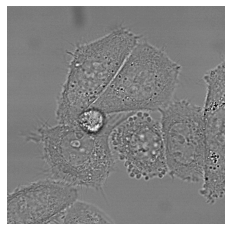

In [9]:
plt.axis('off')
plt.imshow(img, cmap ='gray')

In [10]:
def pred_tta(x, model,aug = TTA_mix):
    pred1 = []
    for aug_cur in aug:
        py1 = np.array(aug_cur((model.predict(x)),
                           fwd=False, mask=True))
        pred1.append(py1)
    pred1 = np.stack(pred1, axis=0)
    return pred1.mean(axis=0)

### Combination of TTA

In [11]:
def TTA_unit(x,fwd=True,mask=False): # raw image without change
    return x

def TTA_flipV(x,fwd=True,mask=False): # Horizontal flip
    return np.flip(np.flip(x, 2), 2) if mask else np.flip(x, 2)

def TTA_flipH(x,fwd=True,mask=False): # Vertical flip
    return np.flip(np.flip(x, 1), 1) if mask else np.flip(x, 1)

def TTA_T(x,fwd=True,mask=False): # Transpose
    return x.T.T if mask else x.T

def TTA_rot_2(x,fwd=True,mask=False): #rotate pi/2
    return TTA_flipV(TTA_flipH(x,fwd,mask),fwd,mask)

def TTA_rot_4cr(x,fwd=True,mask=False): #rotate pi/4 counterclockwise
    return TTA_flipV(TTA_T(x,fwd,mask),fwd,mask) if fwd else \
        TTA_T(TTA_flipV(x,fwd,mask),fwd,mask)

def TTA_rot_4cw(x,fwd=True,mask=False): #rotate pi/4 clockwise
    return TTA_flipH(TTA_T(x,fwd,mask),fwd,mask) if fwd else \
        TTA_T(TTA_flipH(x,fwd,mask),fwd,mask)

def TTA_rot_2T(x,fwd=True,mask=False): #transpose and rotate pi/2
    return TTA_rot_2(TTA_T(x,fwd,mask),fwd,mask)

TTA_raw = [TTA_unit]
TTA_flip = [TTA_unit,TTA_flipH,TTA_flipV,TTA_T]
TTA_mix = [TTA_unit,TTA_flipH,TTA_flipV,TTA_T,TTA_rot_2,TTA_rot_2T,
                 TTA_rot_4cw,TTA_rot_4cr]

### predict the image with TTA

loaded images from directory ../DIC-C2DH-HeLa/05 to shape (1, 512, 512, 1)


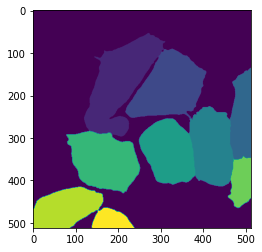

In [12]:
org_img = load_images(img_path)
pred_res = pred_tta(input_img, model)
tta_res = result_show(pred_res, org_img)